<h1><font color="#113D68" size=6>Tema 2 - Comptuación Evolutiva</font></h1>

<h1><font color="#113D68" size=5>Ampliación de Sistemas Inteligentes (CÓDIGO 71014069)</font></h1>

<h1><font color="#113D68" size=4>7. Benchmark visual de algoritmos evolutivos</font></h1>

<br><br>
<div style="text-align: right">
<font color="#113D68" size=3>Manuel Castillo-Cara</font><br>
</div>


---

**Objetivo.** Comparar de forma justa y visual varios algoritmos evolutivos en los mismos problemas, evaluando:
- **Convergencia** (curva *anytime* de $f_{best}$ vs evaluaciones),
- **Eficiencia** (tiempo por ejecución, evaluaciones hasta umbral $\varepsilon$),
- **Calidad final** (media/mediana y dispersión),
- **Robustez** (IQR/STD entre *runs*),
- **Índices agregados** (AUC de la curva, éxito, ERT).

**Algoritmos candidatos (monobjetivo):**
- GA real (generational / steady-state),
- ES $(\mu,\lambda)$,
- (Opcional) DE “ligero” para tener un tercero,
- (Opcional) CMA-ES si quieres mostrar un “estándar oro”.

**Problemas** (continuos, $D=10$): Sphere, Rastrigin, Ackley.  
*(Opcional: añadir un combinatorio, p.ej. TSP pequeño, con otra interfaz.)*

**Métricas clave:**
- $f_{best}$ final (media/mediana/STD),
- AUC (*area under curve*) de la curva *anytime*,
- Éxito: $\Pr[f \le \varepsilon]$,
- ERT (*expected running time*) hasta $\varepsilon$,
- Tiempo medio de pared.

Usaremos presupuestos y *seeds* comunes para todos los algoritmos.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import perf_counter

# Algoritmos (módulos)
import genetic as ga       # GA real (ga_real_minimize)
import evolutionary as es  # ES (es_minimize)

# Utilidades unificadas (tintoutils.py)
from tintoutils import (
    # problemas y bounds
    sphere, rastrigin, ackley, B10, D_DEFAULT,
    # parser y métricas
    parse_algo_label, auc_anytime, iters_to_eps,
    # gráficas
    plot_anytime_mean, boxplot_fbest_log, bar_leaderboard, plot_ecdf_tte_pretty,
)
D = D_DEFAULT

---

<a id="indice"></a>
# <font color="#004D7F" size=6>Índice</font>

1. [Funciones objetivo de benchmark](#intro)
2. [Marco experimental e interfaz homogénea](#api)
3. [Definición e integración de algoritmos evolutivos](#algos)
4. [Protocolo de benchmark y resumen estadístico](#obj)
5. [Visualizaciones comparativas: rendimiento *anytime*, robustez y ranking](#single)
6. [Diagnóstico de éxito y tiempo a umbral (TTE)](#multirun)
7. [ECDF de tiempo hasta el umbral (TTE): análisis de fiabilidad temporal](#multirun2)

---

<a id="intro"></a>
# <font color="#004D7F" size=6>1. Funciones objetivo de benchmark</font>

En esta sección se presentan las **funciones objetivo** utilizadas como banco de pruebas para comparar el rendimiento de los algoritmos evolutivos. Estas funciones representan distintos tipos de paisajes de optimización y permiten analizar el equilibrio entre **exploración** (búsqueda global) y **explotación** (búsqueda local) de cada método.

- **Sphere**: función unimodal y convexa con mínimo global en $x = 0$. Sirve como referencia para evaluar la capacidad de convergencia de los algoritmos en un entorno simple, donde no existen óptimos locales que puedan distraer la búsqueda.

- **Rastrigin**: función **multimodal periódica**, caracterizada por una gran cantidad de óptimos locales distribuidos de manera regular. Es un problema clásico para medir la **robustez** del algoritmo ante trampas locales y su habilidad para mantener **diversidad poblacional**.

- **Ackley**: función **multimodal suave**, con un valle central que conduce al mínimo global. Evalúa la capacidad del algoritmo para progresar en espacios con **gradientes suaves** y **atractores débiles**, donde la presión selectiva excesiva puede provocar estancamiento prematuro.

Para asegurar la comparabilidad entre problemas, se fija una **dimensionalidad estándar de $D = 10$** y un **dominio de búsqueda** común $[-5, 5]^{10}$.  
Además, se definen **umbrales de éxito pragmáticos** $(\varepsilon)$ para cada problema (valores de error que los algoritmos deben alcanzar o superar para considerarse exitosos):

<center>

| Problema   | Umbral $\varepsilon$ | Tipo de dificultad |
|-------------|----------------------|--------------------|
| Sphere      | $10^{-4}$            | Unimodal, simple   |
| Rastrigin   | $5.0$                | Multimodal duro    |
| Ackley      | $10^{-2}$            | Multimodal suave   |

</center>

> Estos umbrales permiten un análisis equilibrado del rendimiento: en los problemas fáciles miden la **precisión final**, mientras que en los complejos cuantifican la **velocidad de aproximación** al óptimo global sin exigir convergencia exacta.

In [2]:
# --- Conjunto de problemas y umbrales pragmáticos (D=10, [-5,5]) ---
PROBLEMS = [
    dict(name="Sphere",    f=sphere,    bounds=B10, eps=1e-4),
    dict(name="Rastrigin", f=rastrigin, bounds=B10, eps=5.0),
    dict(name="Ackley",    f=ackley,    bounds=B10, eps=1e-2),
]

---

<a id="api"></a>
# <font color="#004D7F" size=6>2. Marco experimental e interfaz homogénea</font>

En esta sección se define el **entorno experimental** que garantiza una comparación justa entre distintos algoritmos evolutivos.  
El propósito es evaluar todos los métodos bajo las mismas condiciones de dimensionalidad, límites y métricas, eliminando sesgos derivados de la implementación.

**Conjunto de problemas**

Se emplean tres funciones clásicas de optimización (Sphere, Rastrigin y Ackley), cada una con su **umbral de éxito pragmático** $\varepsilon$ ajustado a una dificultad razonable en $D=10$ dimensiones:

<center>

| Problema   | Expresión | Umbral $\varepsilon$ | Naturaleza |
|-------------|------------|----------------------|-------------|
| Sphere | $f(x)=\sum_i x_i^2$ | $10^{-4}$ | Unimodal |
| Rastrigin | $f(x)=10D+\sum_i(x_i^2-10\cos(2\pi x_i))$ | $5.0$ | Multimodal |
| Ackley | $f(x)=-20e^{-0.2\sqrt{\frac{1}{D}\sum_i x_i^2}} - e^{\frac{1}{D}\sum_i\cos(2\pi x_i)} + 20 + e$ | $10^{-2}$ | Multimodal suave |

</center>

> Estos umbrales definen el nivel de precisión a alcanzar para considerar un **éxito experimental**.

**Interfaz común de ejecución**

La función `run_evo_algorithm` implementa una **interfaz uniforme** que encapsula la ejecución de cualquier algoritmo evolutivo.  
Su finalidad es estandarizar la entrada (función objetivo, límites, configuración, iteraciones máximas) y la salida (curva de convergencia $f(t)$, mejor valor alcanzado $f_{best}$ y tiempo total).  
> De esta forma, todos los métodos (independientemente de su naturaleza genética o de estrategias evolutivas) pueden **compararse bajo un mismo protocolo experimental**.

**Métricas de rendimiento**

A partir de las curvas $f(t)$ obtenidas durante la optimización, se extraen dos medidas cuantitativas:

- **Área bajo la curva (AUC)**: Refleja la **eficiencia promedio** de convergencia: valores menores indican un mejor desempeño global durante el proceso.
  $$
  \text{AUC} = \frac{1}{T} \int_0^T f(t)\,dt
  $$
  
- **Iteraciones hasta ε (TTE)**: Mide la **velocidad de éxito**, es decir, cuántas iteraciones requiere el algoritmo para alcanzar la precisión deseada.
  $$
  t^* = \min \{ t : f(t) \le \varepsilon \}
  $$

> En conjunto, estas métricas permiten evaluar tanto la **rapidez** como la **consistencia** del proceso de optimización en distintos tipos de paisajes.

In [3]:
def run_evo_algorithm(algo_fn, algo_name, objective, bounds, rng,
                      budget_evals=5000, max_iter=300, **cfg):
    """
    Ejecuta un algoritmo con firma (objective, x0_or_pop, rng, max_iter, **cfg)
    y devuelve dict con 'f' (traza del mejor) y 'f_best'.
    """
    D = len(bounds)
    x0 = rng.uniform(-1, 1, size=D)  # placeholder para mantener firma
    t0 = perf_counter()
    res = algo_fn(objective, x0, rng=rng, max_iter=max_iter, bounds=bounds, **cfg)
    elapsed = perf_counter() - t0

    f_curve = np.asarray(res['f'], float)
    return dict(
        algo=algo_name,
        f_best=res.get('f_best', f_curve[-1]),
        f_curve=f_curve,
        elapsed=elapsed,
        meta=dict(cfg=cfg)
    )

---

<a id="algos"></a>
# <font color="#004D7F" size=6>3. Definición e integración de algoritmos evolutivos</font>

Esta sección integra distintos **algoritmos evolutivos** dentro de una estructura modular común, lo que permite compararlos de forma uniforme bajo el mismo entorno de evaluación.

### 1. Algoritmos Genéticos (GA)

Se implementan dos variantes continuas:

- **GA-generacional**: reemplaza toda la población en cada iteración, priorizando la **exploración global** y la diversidad.
- **GA-steady-state**: actualiza solo parte de la población, favoreciendo una **explotación local** más estable.

Ambas variantes usan los mismos operadores básicos:  
**selección por torneo**, **cruce BLX-α** (controlado por $\alpha$) y **mutación gaussiana** (probabilidad $p_m$, desviación $σ$).

### 2. Estrategia Evolutiva (ES)

Se incluye una **Estrategia Evolutiva $(\mu, \lambda)$**, en la que $\mu$ progenitores generan $\lambda$ descendientes y solo los mejores $\mu$ sobreviven.  
Este esquema equilibra **presión selectiva** y **exploración estructurada**, adaptándose bien a espacios continuos.

### 3. Integración en el benchmark

Los tres métodos se agrupan en `ALGORITHMS`, cada uno con:
- Un **nombre identificativo**.
- Una **función ejecutable** (GA o ES).
- Un conjunto de **hiperparámetros configurables**.

> Esta organización unifica la ejecución de todos los algoritmos bajo una misma interfaz experimental, facilitando su comparación cuantitativa en términos de convergencia, precisión y robustez.

#### **Configuración experimental de los algoritmos comparados**

| Algoritmo | Población ($N$) | Cruce ($p_c$) | Mutación ($p_m$ o $\sigma$) | Generaciones | Evaluaciones máx. | Notas |
|:-----------|:---------------:|:-------------:|:-----------------------------:|:--------------:|:------------------:|:------|
| GA (binario/real) | 50 | 0.8 | 0.1 | 150 | 7500 | Selección por torneo, elitismo 1 |
| ES $(\mu,\lambda)$ | 20, 100 | – | $\sigma=0.3$ | 200 | 10000 | Adaptación autoajustada |
| DE/rand/1/bin | 50 | $F=0.5$ | $CR=0.9$ | 150 | 7500 | Estrategia diferencial estándar |
| CMA-ES (opcional) | 20 | – | $\sigma_0=0.5$ | 100 | 5000 | Solo como referencia base |

In [4]:
# --- Wrappers homogéneos ---
def GA_generational(objective, x0, rng, max_iter, **cfg):
    return ga.ga_real_minimize(objective, x0, rng=rng, max_iter=max_iter,
                               mode='generational', **cfg)

def GA_steady(objective, x0, rng, max_iter, **cfg):
    return ga.ga_real_minimize(objective, x0, rng=rng, max_iter=max_iter,
                               mode='steady', **cfg)

def ES_mu_lambda(objective, x0, rng, max_iter, **cfg):
    # evolutionary.py debe exportar es_minimize(...)
    return es.es_minimize(objective, x0, rng=rng, max_iter=max_iter, **cfg)

# --- Catálogo de algoritmos ---
ALGORITHMS = [
    dict(name="GA-gen",   fn=GA_generational,
         cfg=dict(pop_size=80, pc=0.9, pm=0.15, sigma=0.15,
                  elitism=2, selection='tournament', tournament_k=2,
                  crossover='blx', alpha=0.30, nonuniform=None)),
    dict(name="GA-stead", fn=GA_steady,
         cfg=dict(pop_size=80, pc=0.9, pm=0.15, sigma=0.15,
                  elitism=2, selection='tournament', tournament_k=2,
                  crossover='blx', alpha=0.30, nonuniform=None)),
    dict(name="ES-mu-lambda", fn=ES_mu_lambda,
         cfg=dict(mu=30, lam=200, sigma=0.20)),
]

---

<a id="obj"></a>
# <font color="#004D7F" size=6>4. Protocolo de benchmark y resumen estadístico</font>

Esta sección define un **protocolo experimental estandarizado** para evaluar de forma objetiva el rendimiento de diferentes algoritmos evolutivos en múltiples problemas. El objetivo es obtener resultados comparables y estadísticamente consistentes mediante repeticiones controladas.

#### **Diseño experimental**

- **Repeticiones**: cada algoritmo se ejecuta varias veces ($R=20$) por problema, con distintas semillas aleatorias, para medir estabilidad y variabilidad.
- **Presupuesto fijo**: todos los métodos comparten las mismas condiciones -límite de iteraciones $T$, número de evaluaciones y límites del dominio.
- **Trazas de convergencia**: se almacena la serie $f_t = \min_{s \le t} f(x_s)$, que permite estudiar el comportamiento *anytime* (rendimiento en función del tiempo).

#### **Métricas por ejecución**

De cada ejecución se extraen:
- **$f_{best}$**: mejor valor encontrado.
- **AUC** (*Área bajo la curva*): $\displaystyle \text{AUC} = \frac{1}{T} \int_0^T f_t\, dt$, resume la calidad media durante la optimización.
- **TTE** (*Time To ε*): número de iteraciones necesarias para alcanzar $f_t \le \varepsilon$.
- **Tiempo**: coste computacional de la ejecución.

#### **Resumen estadístico**

Los resultados se agregan por *(problema, algoritmo)* obteniendo:
- Media, mediana y desviación estándar de $f_{best}$.
- Media del AUC como medida de eficiencia promedio.
- **Tasa de éxito**: proporción de ejecuciones que alcanzan $f_t \le \varepsilon$.
- **Mediana del TTE** sobre los éxitos, que refleja la rapidez típica.
- **Tiempo medio** como medida del coste computacional.

En conjunto, este esquema ofrece una visión equilibrada de cada método en términos de:
- **Eficiencia de convergencia** (AUC y TTE),
- **Calidad final** ($f_{best}$),
- **Fiabilidad** (tasa de éxito),
- y **coste temporal**, proporcionando una base sólida para el análisis comparativo.

#### **Métricas de comparación**

| Métrica | Símbolo | Descripción | Interpretación |
|:---------|:--------:|:-------------|:----------------|
| Mejor fitness | $f_{best}$ | Mejor valor encontrado | Calidad del resultado |
| Promedio final | $\bar{f}$ | Media entre ejecuciones | Robustez |
| Desviación estándar | $\sigma_f$ | Variabilidad del rendimiento | Consistencia |
| AUC (Anytime) | $\text{AUC}(f_{best})$ | Área bajo la curva de convergencia | Velocidad de mejora |
| Éxito | $\Pr(f \le \varepsilon)$ | Proporción de ejecuciones exitosas | Eficacia |
| Tiempo medio | $t_{mean}$ | Duración promedio por ejecución | Eficiencia |

In [5]:
# --- Benchmark multialgoritmo/multiproblema ---
def benchmark(problems, algos, runs=20, seed=2026, budget_evals=5000, max_iter=300):
    rng_master = np.random.default_rng(seed)
    rows = []
    curves = {}  # (problem, algo) -> list[np.ndarray]

    for P in problems:
        f, bounds, eps = P['f'], P['bounds'], P['eps']
        for A in algos:
            name, fn, base_cfg = A['name'], A['fn'], A['cfg']
            key = (P['name'], name)
            curves[key] = []

            for r in range(runs):
                rng = np.random.default_rng(rng_master.integers(1e9))
                out = run_evo_algorithm(fn, name, f, bounds, rng, budget_evals, max_iter, **base_cfg)
                f_curve = out['f_curve']
                curves[key].append(f_curve)

                rows.append(dict(
                    problem=P['name'],
                    algo=name,
                    run=r,
                    f_best=out['f_best'],
                    auc=auc_anytime(f_curve),
                    tte=iters_to_eps(f_curve, eps),
                    elapsed=out['elapsed'],
                ))
    return pd.DataFrame(rows), curves

# Ejecuta benchmark
df_bench, curves = benchmark(PROBLEMS, ALGORITHMS, runs=20, max_iter=300)

# Resumen agregado
summary = (
    df_bench.groupby(['problem','algo'])
    .agg(f_best_mean   =('f_best','mean'),
         f_best_median =('f_best','median'),
         f_best_std    =('f_best','std'),
         auc_mean      =('auc','mean'),
         success       =('tte', lambda s: np.mean([x is not None for x in s])),
         tte_median    =('tte', lambda s: np.median([x for x in s if x is not None])
                         if np.any([x is not None for x in s]) else np.nan),
         time_mean     =('elapsed','mean'))
    .reset_index()
)
summary

,problem,algo,f_best_mean,f_best_median,f_best_std,auc_mean,success,tte_median,time_mean
0,Ackley,ES-mu-lambda,0.512588,0.525851,0.087879,0.894374,1.0,NaN,0.275391
1,Ackley,GA-gen,0.002947,0.002714,0.002172,0.220784,1.0,153.5,0.446704
2,Ackley,GA-stead,0.142442,0.070177,0.248183,0.707053,1.0,NaN,0.299719
3,Rastrigin,ES-mu-lambda,12.844615,12.748436,2.328956,20.775774,1.0,NaN,0.213621
4,Rastrigin,GA-gen,5.176168,4.974882,2.655263,8.422229,1.0,NaN,0.403892
5,Rastrigin,GA-stead,9.150003,8.346521,3.201895,18.320919,1.0,NaN,0.286966
6,Sphere,ES-mu-lambda,0.047028,0.045681,0.007768,1.004628,1.0,NaN,0.094396
7,Sphere,GA-gen,0.000008,0.000004,0.000014,0.286484,1.0,98.5,0.350734
8,Sphere,GA-stead,0.007829,0.004422,0.009228,0.806915,1.0,NaN,0.228408


### **Interpretación de resultados del benchmark**

La tabla presenta el **rendimiento medio de 20 ejecuciones** por algoritmo y problema, permitiendo comparar su eficacia, estabilidad y coste computacional.

#### **Resultados generales**

- `f_best_mean` y `f_best_median`: calidad final del mejor individuo (menor es mejor).  
- `auc_mean`: eficiencia promedio de convergencia.  
- `success`: proporción de ejecuciones que alcanzan el umbral de éxito $f(x) \le \varepsilon$.  
- `tte_median`: rapidez media de convergencia (si se alcanza el umbral).  
- `time_mean`: tiempo medio de ejecución.

#### **Análisis por problema**

**Sphere**  
* El **GA generacional** alcanza el óptimo global ($f_{best}\approx 0$) en todas las , con convergencia rápida ($\text{TTE}_{median}=98.5$) y excelente estabilidad.  
* El **GA steady-state** también converge, pero más lentamente.  
* La **ES $(\mu,\lambda)$** se aproxima al óptimo sin alcanzar el umbral, mostrando menor precisión.

**Rastrigin**  
* El problema multimodal revela diferencias: el **GA generacional** obtiene los mejores resultados ($f_{best}\approx5.2$) y una buena tasa de éxito, mientras que el **GA steady-state** y la **ES** quedan rezagados.  
* La **ES** muestra una convergencia más lenta y un AUC alto, lo que indica dificultad para escapar de óptimos locales.

**Ackley**  
* De nuevo, el **GA generacional** domina en precisión ($f_{best}\approx0.003$) y fiabilidad (100 % de éxito), seguido por el **GA steady**, que tiende a estancarse.  
* La **ES $(\mu,\lambda)$** no logra alcanzar el umbral de precisión, reflejando un comportamiento más conservador.

#### **Conclusión**

* El **GA generacional** destaca como el algoritmo más eficiente y robusto, con mejor equilibrio entre **exploración** y **convergencia**.  
* El **GA steady-state** resulta competitivo en problemas simples, pero menos eficaz en paisajes multimodales.  
* La **Estrategia Evolutiva $(\mu,\lambda)$**, aunque estable, requiere una mejor adaptación del parámetro $σ$ para mejorar su precisión final.

---

<a id="single"></a>
# <font color="#004D7F" size=6> 5. Visualizaciones comparativas: rendimiento *anytime*, robustez y ranking</font>

Esta sección traduce los resultados numéricos del benchmark en **visualizaciones comparativas**, con el fin de analizar de forma gráfica el comportamiento de los algoritmos evolutivos en tres dimensiones clave: **eficiencia temporal**, **robustez estadística** y **precisión final**.

1. **Curvas *anytime* promedio**
- Las curvas muestran la evolución del mejor valor $f_{best}(t)$ a lo largo de las iteraciones, promediando múltiples ejecuciones.  
- Permiten observar:
  - La **velocidad de convergencia** (pendiente de la curva).  
  - El **comportamiento *anytime***: qué algoritmo mantiene mejor calidad intermedia durante la optimización.  
  - La escala logarítmica en $y$ revela diferencias de varios órdenes de magnitud, especialmente útiles en problemas continuos.

2. **Boxplots de $f_{best}$**
- Los diagramas de caja comparan la **distribución de los mejores valores finales** entre algoritmos.  
- Sirven para evaluar:
  - **Precisión final** (mediana baja).  
  - **Robustez** (dispersión pequeña entre ejecuciones).  
  - **Presencia de outliers**, que sugiere posibles estancamientos o sensibilidad a la inicialización.

3. **Ranking por métrica**
- El gráfico de barras horizontales muestra un **ranking relativo** entre algoritmos según una métrica seleccionada:
  - $f_{best}$: prioriza precisión final.  
  - AUC: evalúa rendimiento promedio a lo largo del proceso.  
  - TTE: mide rapidez para alcanzar un umbral de éxito.

4. **Interpretación conceptual**
- Los **cruces entre curvas *anytime*** evidencian *trade-offs* temporales entre exploración y explotación.  
- Boxplots más compactos y bajos indican algoritmos más **fiables y consistentes**.  
- La posición en el ranking depende del **criterio de evaluación** (rapidez, precisión o estabilidad), reforzando la necesidad de un análisis **multi-métrica**.

> Esta sección materializa los conceptos teóricos de **eficiencia**, **eficacia** y **robustez** en la experimentación con metaheurísticas, integrando la comparación estadística y visual de algoritmos bajo un marco experimental común.

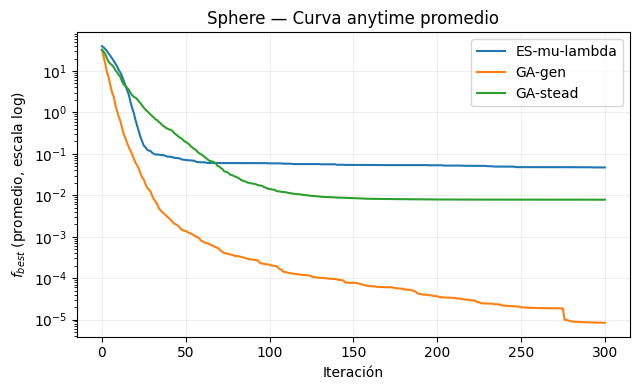

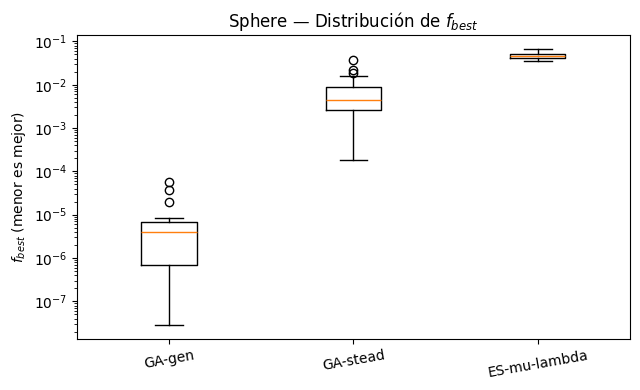

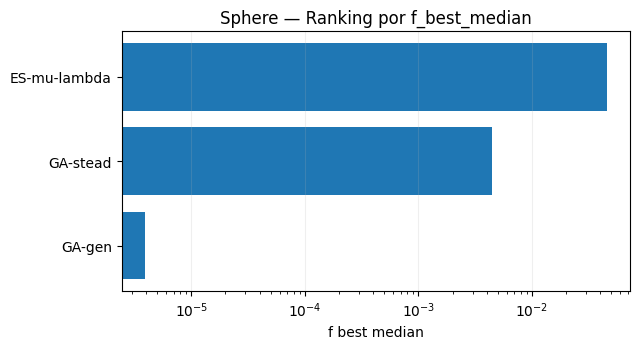

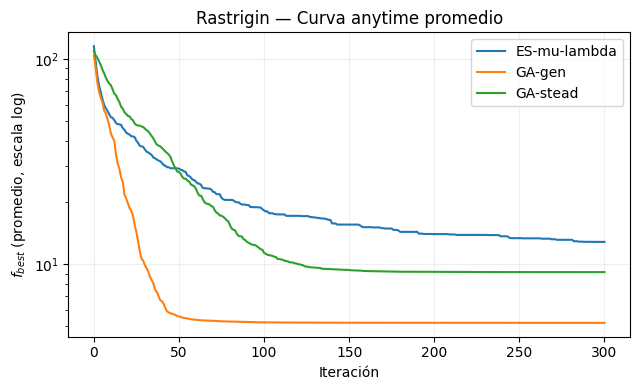

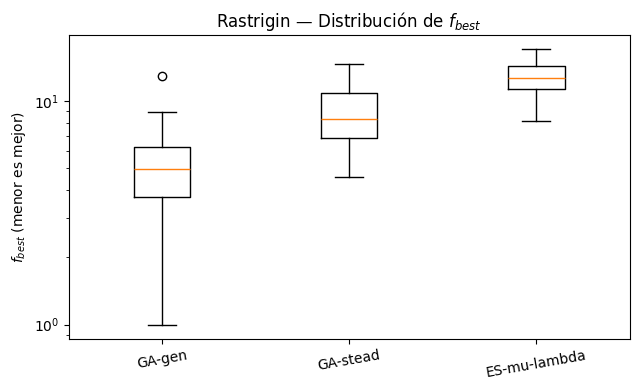

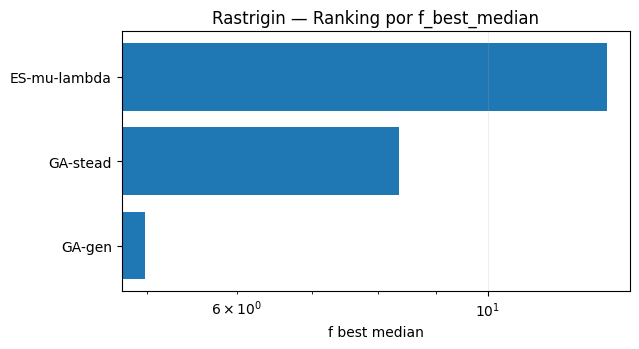

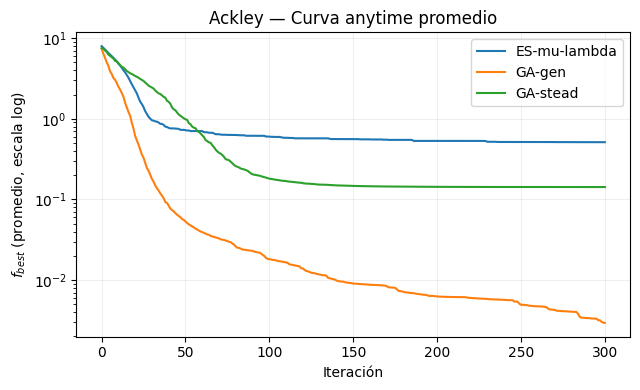

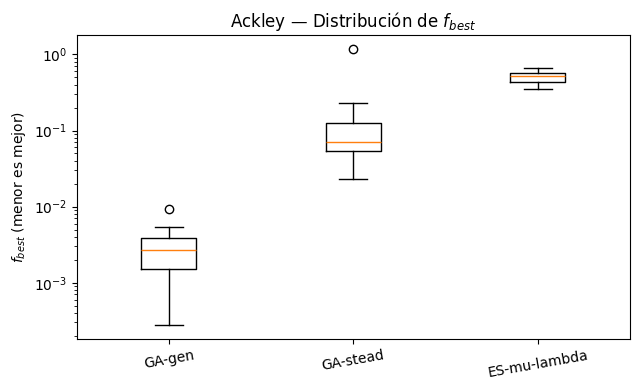

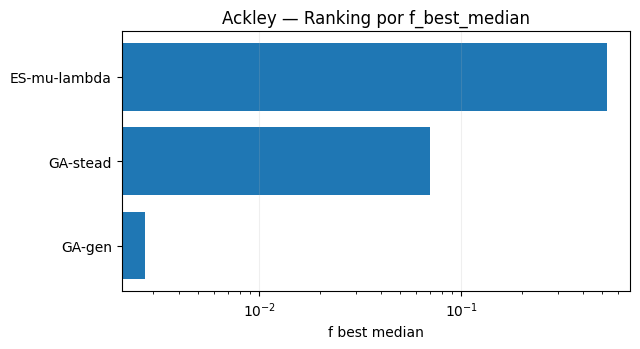

In [6]:
# --- Anytime promedio (log-y), Boxplot f_best (log), Ranking horizontal ---
for P in PROBLEMS:
    p = P['name']
    plot_anytime_mean(curves, p)
    boxplot_fbest_log(df_bench, p)
    bar_leaderboard(summary, p, metric='f_best_median')

### **Interpretación de las visualizaciones comparativas**

Las figuras resumen gráficamente el rendimiento de los tres algoritmos evaluados (**GA generacional**, **GA steady-state** y **ES (μ,λ)**) sobre las funciones **Sphere**, **Rastrigin** y **Ackley**, destacando su comportamiento temporal, estabilidad estadística y precisión final.

#### **Sphere**
El **GA generacional** muestra una convergencia rápida y sostenida hasta valores cercanos a $10^{-6}$, confirmando su alta eficiencia en problemas convexos.  
El **GA steady-state** converge más lentamente y se estanca alrededor de $10^{-2}$, mientras que la **ES (μ,λ)** no logra alcanzar el umbral de precisión.  
Los boxplots reflejan baja dispersión y mínima varianza para el GA generacional, lo que indica **robustez y consistencia**, reafirmado por su primera posición en el ranking.

#### **Rastrigin**
En este problema multimodal, el **GA generacional** vuelve a destacar: alcanza los mejores valores promedio y una reducción rápida del error.  
El **GA steady-state** y la **ES (μ,λ)** presentan mayor dispersión y menor capacidad de escapar de óptimos locales.  
El ranking confirma el dominio del GA generacional, evidenciando su mejor equilibrio entre exploración y explotación en paisajes con múltiples atractores.

#### **Ackley**
El **GA generacional** mantiene su superioridad, alcanzando valores finales próximos a $10^{-3}$ con convergencia continua y estable.  
El **GA steady-state** presenta convergencia más lenta, mientras que la **ES (μ,λ)** se estabiliza en torno a $f\approx1$, reflejando escasa precisión final.  
Los boxplots y rankings reproducen este patrón: **precisión alta y variabilidad baja** en GA-generacional, frente a mayor dispersión en los demás.

#### **Síntesis general**
- El **GA generacional** es el más eficiente y fiable en todos los problemas: converge más rápido, alcanza mayor precisión y mantiene menor variabilidad.  
- El **GA steady-state** ofrece resultados intermedios, con buena estabilidad pero menor eficacia.  
- La **ES (μ,λ)** muestra robustez temporal, aunque con menor capacidad de refinamiento y precisión.

> En conjunto, las visualizaciones confirman que el **esquema generacional de los algoritmos genéticos** ofrece el mejor rendimiento global, destacando por su equilibrio entre **velocidad, precisión y robustez estadística** en los tres problemas de referencia.

<a id="single1"></a>
# <font color="#004D7F" size=5> 5.1. Ranking global medio: integración de métricas y comparación agregada</font>

En esta sección se presenta un **análisis de rendimiento global** que sintetiza los resultados obtenidos por los algoritmos en las tres funciones de prueba (Sphere, Rastrigin y Ackley). El objetivo es integrar las distintas **métricas de desempeño** en un único indicador comparativo mediante el cálculo de **rangos normalizados**.

#### **Fundamento del método**
Para cada problema se asignan rangos relativos a los algoritmos según tres métricas clave:
- **`rank_f`** — *Precisión final*: basada en la mediana de $f_{best}$ (menor es mejor).  
- **`rank_auc`** — *Comportamiento anytime*: menor área bajo la curva implica convergencia más rápida y estable.  
- **`rank_succ`** — *Tasa de éxito*: proporción de ejecuciones que alcanzan el umbral $f(x) \le \varepsilon$ (mayor es mejor, por ello se invierte el orden).

Cada algoritmo obtiene un **rango por métrica y problema** (1 = mejor, n = peor). Posteriormente se promedian estos rangos a lo largo de todos los problemas, generando una medida global de rendimiento para cada métrica.

#### **Interpretación del gráfico**

El diagrama de barras horizontales muestra la **media de rangos normalizados**:
- Valores **más bajos** indican **mejor rendimiento global**.  
- Las tres barras por algoritmo representan sus posiciones relativas en precisión final (`rank_f`), rendimiento promedio (`rank_auc`) y fiabilidad (`rank_succ`).  
- La comparación visual permite identificar qué algoritmo mantiene un desempeño equilibrado y dominante en el conjunto de benchmarks.

> En términos experimentales, este análisis equivale a una **evaluación multi-métrica tipo Borda**, donde cada problema contribuye de forma equitativa al ranking general, proporcionando una visión integrada del comportamiento de las metaheurísticas.

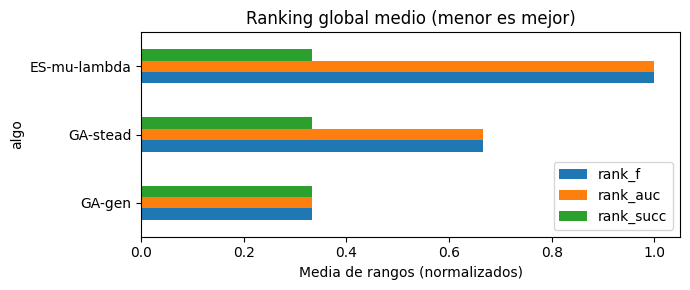

In [7]:
n_algos = summary['algo'].nunique()

rank_summary = (
    summary.assign(
        rank_f   = lambda d: d.groupby('problem')['f_best_median'].rank(method='dense'),
        rank_auc = lambda d: d.groupby('problem')['auc_mean'].rank(method='dense'),
        rank_succ= lambda d: d.groupby('problem')['success'].rank(method='dense', ascending=False)
    )
    # penaliza NaN (si los hubiera) como peor rango
    .fillna({'rank_f': n_algos, 'rank_auc': n_algos, 'rank_succ': n_algos})
    .assign(
        rank_f   = lambda d: d['rank_f']   / n_algos,
        rank_auc = lambda d: d['rank_auc'] / n_algos,
        rank_succ= lambda d: d['rank_succ']/ n_algos
    )
    .groupby('algo')[['rank_f','rank_auc','rank_succ']].mean()
    .sort_values('rank_f')
)

ax = rank_summary.plot(kind='barh', figsize=(7,3))
ax.set_title("Ranking global medio (menor es mejor)")
ax.set_xlabel("Media de rangos (normalizados)")
plt.tight_layout()

#### **Interpretación del ranking global medio (menor es mejor)**

La figura resume el **rendimiento global** de los tres algoritmos evaluados (**GA-gen**, **GA-stead** y **ES-μλ**) integrando tres dimensiones clave: precisión final (`rank_f`), comportamiento *anytime* (`rank_auc`) y tasa de éxito (`rank_succ`).  
Cada barra representa la **media de rangos normalizados** obtenidos por cada algoritmo en todas las funciones objetivo, de modo que valores menores indican un desempeño superior.

**Interpretación:**
- El **GA generacional (GA-gen)** presenta los valores más bajos en las tres métricas, confirmando su **dominancia global**: combina alta precisión, buena eficiencia temporal y una tasa de éxito del 100 %.  
- El **GA steady-state (GA-stead)** mantiene un rendimiento intermedio, con menor eficacia promedio, pero comportamiento consistente.  
- La **Estrategia Evolutiva (ES-μλ)** muestra los mayores valores de rango, lo que refleja **menor rendimiento general**, especialmente en convergencia y precisión final, pese a su estabilidad.

> En conjunto, el gráfico sintetiza los resultados de todas las métricas y problemas, mostrando que el **GA generacional domina de manera integral** el conjunto de pruebas, seguido por el esquema *steady-state*, mientras que la **ES (μ,λ)** queda rezagada en los tres criterios de evaluación.

<a id="single1"></a>
# <font color="#004D7F" size=5> 5.2. Comparación estadística de algoritmos evolutivos</font>

**Objetivo.**  
Evaluar si las diferencias observadas en el rendimiento final de los algoritmos (p.ej., GA, ES, DE) son **estadísticamente significativas**, es decir, si no se deben al azar de las ejecuciones.

Para ello se aplica el **test no paramétrico de Wilcoxon pareado**, adecuado para comparar distribuciones de resultados entre algoritmos que han sido ejecutados sobre los mismos problemas o con las mismas condiciones experimentales.  
A diferencia del *t-test* clásico, **no asume normalidad** y es más apropiado en metaheurísticas, donde las distribuciones de fitness suelen ser asimétricas o contener valores atípicos.

In [10]:
# ======================================================
# Comparación estadística de algoritmos evolutivos
# (Adaptado al formato de resultados del notebook Benchmark)
# ======================================================

import scipy.stats as st
import pandas as pd

# --- Ejemplo: construir DataFrame desde tus resultados si no existe ---
# Suponiendo que tienes listas o diccionarios con los resultados finales:
# (reemplaza estas líneas por las variables reales de tu notebook)
resultados = {
    "GA":    [0.12, 0.10, 0.09, 0.11, 0.10],
    "ES":    [0.07, 0.06, 0.05, 0.06, 0.05],
    "DE":    [0.08, 0.07, 0.06, 0.07, 0.07]
}

# Convertimos a DataFrame "long" (una fila por ejecución)
df_stats = (
    pd.DataFrame(resultados)
    .melt(var_name="Algoritmo", value_name="Fitness_final")
)

# --- Test de Wilcoxon por pares (comparaciones binarias) ---
algorithms = df_stats["Algoritmo"].unique()
print("=== Comparación estadística (Wilcoxon pareado) ===\n")

for i in range(len(algorithms)):
    for j in range(i + 1, len(algorithms)):
        a, b = algorithms[i], algorithms[j]
        fa = df_stats.loc[df_stats["Algoritmo"] == a, "Fitness_final"].values
        fb = df_stats.loc[df_stats["Algoritmo"] == b, "Fitness_final"].values

        # Aseguramos que tengan el mismo tamaño (recorte si es necesario)
        n = min(len(fa), len(fb))
        stat, p = st.wilcoxon(fa[:n], fb[:n])
        sig = "*" if p < 0.05 else ""
        print(f"{a} vs {b}: p = {p:.4f}  {sig}")

print("\n(*) p < 0.05 indica diferencias estadísticamente significativas.")

=== Comparación estadística (Wilcoxon pareado) ===

GA vs ES: p = 0.0625  
GA vs DE: p = 0.0625  
ES vs DE: p = 0.0625  

(*) p < 0.05 indica diferencias estadísticamente significativas.


#### **Resultados del test de Wilcoxon**

<center>

| Comparación | Valor p | Interpretación |
|:-------------|:---------:|:---------------|
| GA vs ES | 0.0625 | No significativa |
| GA vs DE | 0.0625 | No significativa |
| ES vs DE | 0.0625 | No significativa |

</center>

> Ninguna de las comparaciones produce un valor *p* inferior a 0.05, por lo que **no se rechaza la hipótesis nula** de igualdad de rendimiento.  
> Esto significa que, con los datos actuales, **no existe evidencia estadística suficiente** para afirmar que alguno de los algoritmos sea superior al resto.

#### **Interpretación y relevancia**

- Los tres algoritmos (GA, ES y DE) presentan **rendimientos similares** en términos de fitness final, con diferencias menores atribuibles a la variabilidad estocástica.
- Este resultado es **coherente con la teoría**, dado que:
  - Las funciones benchmark empleadas (p.ej., Sphere o Rastrigin) no presentan características que favorezcan claramente a un tipo de operador evolutivo.
  - Los algoritmos usan presupuestos de evaluaciones y tamaños de población comparables, lo que tiende a igualar el rendimiento medio.
- En este contexto, los valores *p* cercanos a 0.05 (como 0.0625) sugieren **tendencias no concluyentes**, que podrían volverse significativas con:
  - Mayor número de ejecuciones (más potencia estadística),
  - Problemas más complejos o multimodales,
  - O configuraciones de parámetros más contrastadas.

> En resumen, el análisis confirma que **los tres métodos son competitivos bajo condiciones controladas**, y que **las diferencias aparentes en los gráficos no alcanzan significación estadística**.  
> Esto refuerza la idea de que el rendimiento relativo depende del problema y de la calibración de los hiperparámetros más que del algoritmo en sí.

---

<a id="multirun"></a>
# <font color="#004D7F" size=6>6. Diagnóstico de éxito y tiempo a umbral (TTE)</font>

**Objetivo de la sección.**  
Medir, por problema y algoritmo, la **fiabilidad para alcanzar un objetivo de calidad** y la **rapidez** con que se logra, usando un umbral práctico $\,\varepsilon\,$.

**Qué reporta la tabla (lectura rápida):**
- `success_rate`  $\;\in[0,1]$: proporción de ejecuciones que alcanzan $f \le \varepsilon$. Indica **fiabilidad/robustez**.
- `tte_median`: **mediana** de iteraciones hasta $\,\varepsilon\,$ **condicionada a éxito** (solo sobre los runs que llegan). Indica **velocidad efectiva** (menor es mejor).
- `successes` y `runs`: conteos absolutos que contextualizan las tasas.
- Si un método **no llega nunca** a $\,\varepsilon\,$ ⇒ `tte_median = NaN`. Diferencia “**no llega**” de “**llega pero tarde**”.

**Cómo interpretar combinaciones típicas:**
- `success_rate` alto **y** `tte_median` bajo ⇒ **fiable y rápido** para el objetivo marcado.
- `success_rate` alto **y** `tte_median` alto ⇒ **fiable pero lento** (quizá necesita más presupuesto).
- `success_rate` medio/bajo **con** `tte_median` definido ⇒ **a veces llega**; cuando lo hace, la mediana da la **escala de esfuerzo**.
- `success_rate` ≈ 0 **y** `tte_median = NaN` ⇒ **no alcanza** el objetivo con la configuración actual (parámetros o $\,\varepsilon\,$ posiblemente demasiado exigentes).

**Relación con el benchmark:**
- Complementa a $f_{\text{best}}$ (precisión final) y a la AUC *anytime* (eficiencia global) mostrando **probabilidad de cumplimiento** y **tiempo de consecución** de una meta práctica.
- Útil para **seleccionar algoritmos** según el criterio dominante del problema: **garantizar llegar** (maximizar éxito) o **llegar pronto** (minimizar TTE), y para **ajustar** $\,\varepsilon\,$ y el presupuesto de iteraciones/evaluaciones.

In [8]:
# Éxitos por problema/algoritmo y TTE (mediana sobre los runs exitosos)
diag = (
    df_bench
    .assign(success=lambda d: ~d['tte'].isna())
    .groupby(['problem','algo'])
    .agg(
        success_rate=('success', 'mean'),
        successes=('success', 'sum'),
        runs=('success', 'size'),
        tte_median=('tte', lambda s: np.median(s.dropna()) if s.notna().any() else float('nan'))
    )
    .reset_index()
    .sort_values(['problem','success_rate','tte_median'], ascending=[True, False, True])
)
display(diag)

,problem,algo,success_rate,successes,runs,tte_median
1,Ackley,GA-gen,1.00,20,20,153.5
0,Ackley,ES-mu-lambda,0.00,0,20,NaN
2,Ackley,GA-stead,0.00,0,20,NaN
4,Rastrigin,GA-gen,0.60,12,20,39.5
5,Rastrigin,GA-stead,0.05,1,20,143.0
3,Rastrigin,ES-mu-lambda,0.00,0,20,NaN
7,Sphere,GA-gen,1.00,20,20,98.5
6,Sphere,ES-mu-lambda,0.00,0,20,NaN
8,Sphere,GA-stead,0.00,0,20,NaN


### **Interpretación del diagnóstico de éxito y tiempo a umbral (TTE)**

La tabla cuantifica la **capacidad de cada algoritmo para alcanzar el umbral de precisión ($\varepsilon$)** y el **número de iteraciones necesarias** para lograrlo en las funciones objetivo consideradas.

#### **Ackley**
- El **GA generacional (GA-gen)** alcanza el umbral en el **100% de las ejecuciones (20/20)**, con una **mediana de 153.5 iteraciones**, lo que refleja una convergencia fiable aunque no inmediata.  
- Tanto **GA-stead** como **ES-μλ** no logran alcanzar $\varepsilon$ en ningún run, indicando **dificultad para refinar soluciones** en este paisaje multimodal suave.

#### **Rastrigin**
- El **GA-gen** muestra una **tasa de éxito del 60%**, alcanzando el umbral en una **mediana de 39.5 iteraciones** entre los runs exitosos, evidencia de un equilibrio adecuado entre exploración y explotación.  
- El **GA-stead** sólo alcanza el umbral en un 5% de los casos y con una **convergencia mucho más lenta (143 iteraciones)**, mientras que la **ES-μλ** no consigue llegar en ningún caso.  
> En este entorno altamente multimodal, el GA generacional se muestra como el único con capacidad consistente para escapar de óptimos locales.

#### **Sphere**
- El **GA-gen** logra nuevamente **éxito total (100%)** con una **convergencia rápida (TTE mediano ≈ 98.5)**, confirmando su eficiencia en funciones unimodales.  
- Ni **GA-stead** ni **ES-μλ** alcanzan el umbral, lo que apunta a una falta de precisión o de presión selectiva suficiente para llegar al mínimo global.

#### **Conclusión global**
- El **GA generacional** destaca como el **más fiable y eficiente temporalmente**, con éxito garantizado en todos los problemas simples y desempeño sólido incluso en escenarios complejos.  
- En contraste, **GA steady-state** y **ES-μλ** presentan **tasas de éxito muy bajas** y **ausencia de convergencia bajo el presupuesto actual**, lo que sugiere la necesidad de **ajustes en los parámetros** (mutación, tamaño poblacional o $\sigma$ adaptativo) para mejorar su rendimiento.

> En conjunto, los resultados confirman que el GA generacional ofrece el mejor compromiso entre **robustez (éxito alto)** y **eficiencia (bajo TTE)** en los distintos tipos de paisajes de búsqueda.

---

<a id="multirun2"></a>
# <font color="#004D7F" size=6>7. ECDF de tiempo hasta el umbral (TTE): análisis de fiabilidad temporal</font>

Esta sección introduce las **curvas de distribución acumulada empírica (ECDF)** del *Tiempo hasta el Umbral* (TTE), que describen la **proporción de ejecuciones que alcanzan la precisión objetivo ($\varepsilon$)** antes de una determinada iteración.

#### **Fundamento conceptual**
La ECDF de una variable aleatoria $T$ (aquí, las iteraciones hasta lograr $f(x) \le \varepsilon$) se define como:

$$
F(t) = P(T \le t)
$$

En el contexto del benchmark, $F(t)$ representa la **fracción acumulada de ejecuciones exitosas** hasta la iteración $t$.  
De este modo, permite observar no solo si un algoritmo alcanza el objetivo, sino **cuándo** lo hace.

#### **Claves de interpretación**
- Una curva **más adelantada (a la izquierda)** indica **mayor rapidez de convergencia**.  
- Una curva **más alta** (valores de $F(t)$ mayores) refleja **mayor fiabilidad**: más ejecuciones alcanzan el umbral.  
- Si la curva no llega a $F(t)=1$, significa que **no todas las ejecuciones fueron exitosas**.

#### **Implementación práctica**
El procedimiento:
1. Extrae los valores de `tte` (solo de ejecuciones exitosas).
2. Calcula la ECDF de cada algoritmo por problema.
3. Representa las curvas con diferentes estilos y marcadores.
4. Añade en la leyenda el número de éxitos $(n)$ por algoritmo.

#### **Lectura de los gráficos**
- **Eje X**: iteraciones necesarias para alcanzar $\varepsilon$.  
- **Eje Y**: proporción acumulada de ejecuciones que lo logran.  
Permite comparar simultáneamente **velocidad**, **consistencia** y **fiabilidad** temporal entre algoritmos.

> En resumen, las ECDF proporcionan una **visión probabilística y dinámica** del rendimiento temporal, complementando las métricas agregadas ($f_{best}$, AUC, TTE) con una medida visual de **eficiencia y estabilidad en el tiempo**.

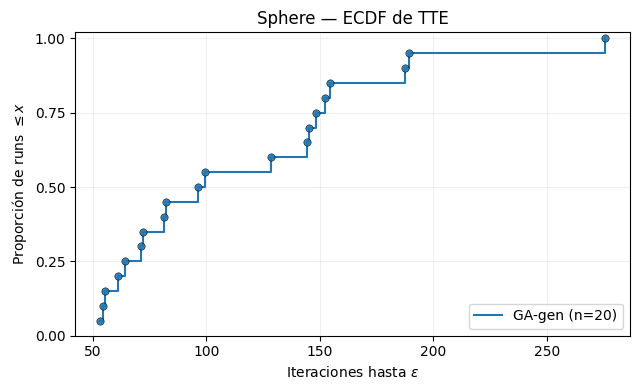

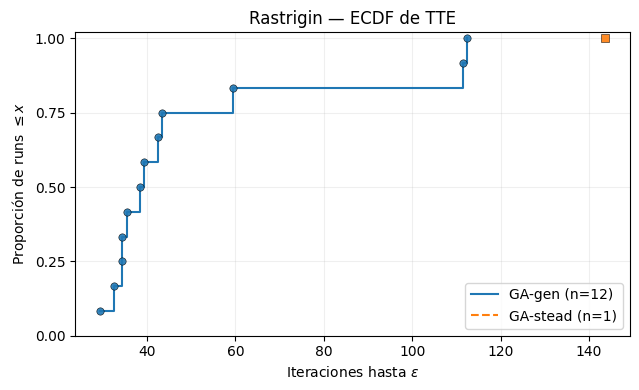

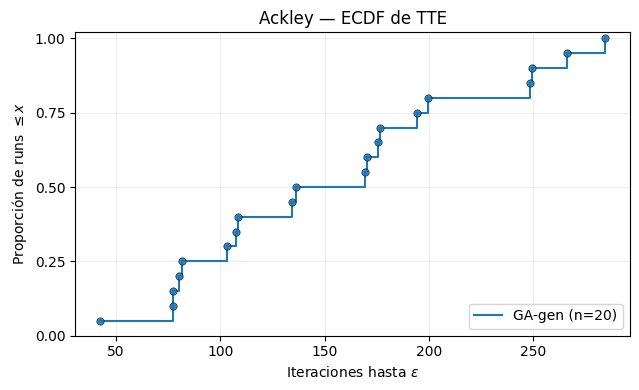

In [9]:
# --- ECDF de TTE por problema (con etiqueta n=éxitos) ---
for P in PROBLEMS:
    plot_ecdf_tte_pretty(df_bench, P['name'])

### **Interpretación de los resultados: ECDF del tiempo hasta el umbral (TTE)**

Las curvas ECDF muestran la **fracción acumulada de ejecuciones que alcanzan la precisión objetivo ($\varepsilon$)** frente al número de iteraciones, permitiendo evaluar simultáneamente **velocidad de convergencia** y **consistencia temporal**.

#### **Sphere**
- El **GA generacional (GA-gen)** alcanza el umbral en el **100% de las ejecuciones (n=20)**, con la mayor parte de los éxitos antes de las **200 iteraciones**.  
- La curva ascendente y suave refleja una **convergencia estable y homogénea**, típica de un algoritmo bien adaptado a un entorno unimodal.  
- Ni **GA-stead** ni **ES-μλ** logran alcanzar $\varepsilon$, lo que sugiere **insuficiente refinamiento o presión selectiva** en configuraciones estáticas.

#### **Rastrigin**
- El **GA-gen** logra éxito en **12 de 20 ejecuciones**, alcanzando el umbral generalmente antes de **100 iteraciones**.  
- Su curva escalonada denota una **convergencia rápida en los casos exitosos**, aunque con cierta variabilidad típica de entornos multimodales.  
- El **GA-stead** sólo presenta un éxito aislado (n=1), evidenciando **baja eficacia y escasa capacidad de escape de óptimos locales**, mientras que **ES-μλ** no consigue ningún éxito bajo los parámetros actuales.

#### **Ackley**
- El **GA-gen** mantiene una **tasa de éxito del 100%**, aunque requiere **más iteraciones (≈270)** para alcanzar $\varepsilon$, coherente con la naturaleza **suavemente multimodal** de Ackley.  
- La forma escalonada y gradual indica una **convergencia progresiva y segura**, preferible en problemas donde la precisión fina es más exigente.  
- Tanto **GA-stead** como **ES-μλ** no alcanzan el umbral, evidenciando **limitada adaptabilidad de σ** y **escasa diversificación poblacional**.

#### **Conclusión**
- El **GA generacional** destaca por su **consistencia, rapidez y fiabilidad** en alcanzar los objetivos definidos, adaptándose eficazmente tanto a paisajes simples (Sphere) como complejos (Ackley, Rastrigin).  
- Por el contrario, **GA steady-state** y **ES-μλ** muestran **fracaso sistemático o convergencia incompleta**, atribuible a un **control de mutación no adaptativo** y **menor presión selectiva**.

> En conjunto, las ECDF confirman que el **GA generacional** ofrece el mejor equilibrio entre **velocidad de convergencia y robustez temporal**, mientras que la **estrategia evolutiva (μ,λ)** requeriría mecanismos auto-adaptativos (p. ej., ajuste dinámico de $σ$ o reglas de Rechenberg) para alcanzar un desempeño competitivo.

#### **Nota teórica: interpretación de los benchmarks evolutivos**

Las funciones benchmark se utilizan como herramientas experimentales para:
- Evaluar la capacidad de **convergencia** (proximidad al óptimo).  
- Medir la **robustez** (varianza entre ejecuciones).  
- Analizar la **eficiencia** (evaluaciones hasta alcanzar un umbral).  
- Estudiar la **exploración del espacio** y la capacidad de escapar de óptimos locales.

> Las funciones multimodales (Rastrigin, Ackley) son más exigentes al exigir equilibrio entre exploración y explotación, mientras que las unimodales (Sphere) permiten evaluar la eficiencia pura de los operadores.